# Testing K-means Clustering Algorithm

Interact via IO and various drivers:
* root/run.f90   

In [18]:
"""Set up grid
"""
%load_ext autoreload
%autoreload 2

import numpy as np

# Grid settings
n_x = n_y = 50
limits_x = (0, 10)
limits_y = (0, 10)

# Define a grid of points in 2D space
x = np.linspace(*limits_x, n_x)
y = np.linspace(*limits_y, n_y)
X, Y = np.meshgrid(x, y)

# Grid to define Gaussians
grid = np.dstack((X, Y))
assert grid.shape == (n_x, n_y, 2), 'Nx, Ny, Ndim'

# Reshape for format expected by kmeans algorithm
# i.e. grid[1, 0, :] == grid_reshaped[40, :]
flat_grid = grid.reshape(-1, 2)
assert flat_grid.shape == (n_x * n_y, 2), 'Npoints, Ndim'

# print(flat_grid.shape)
# for p in flat_grid:
#     print(p)

# Write grid settings for parsing by fortran program
with open("grid_settings.dat", "w") as fid:
    fid.write("# start   stop   n_points \n")
    string = " ".join(str(s) for s in limits_x) + " " + str(n_x) + "\n"
    fid.write(string)
    string = " ".join(str(s) for s in limits_y) + " " + str(n_y) + "\n"
    fid.write(string)
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
"""Set up Gaussians on grid
"""
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

# Place a Gaussian distribution in each quadrant of the cubic grid
mu1 = [2.5, 2.5]
mu2 = [7.5, 2.5]
mu3 = [2.5, 7.5]
mu4 = [7.5, 7.5]
cov = [[0.75, 0], [0, 0.75]]  # Covariance matrix: Diagonals are variances == std^2 i.e. (Gaussian width)^2

z1 = multivariate_normal.pdf(grid, mean=mu1, cov=cov)
z2 = multivariate_normal.pdf(grid, mean=mu2, cov=cov)
z3 = multivariate_normal.pdf(grid, mean=mu3, cov=cov)
z4 = multivariate_normal.pdf(grid, mean=mu4, cov=cov)
z_total = z1 + z2 + z3 + z4

visualise_gaussians_in_3d = True

if visualise_gaussians_in_3d:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, z_total, cmap='viridis')
    plt.show()

# Output total gaussian for parsing by fortran
np.savetxt("weights.dat", z_total.reshape(-1))



AttributeError: module 'matplotlib' has no attribute 'backend_bases'

In [ ]:
"""Output initial centroids
"""
import subprocess
import os

n_iterpolation_points = 25
nr = flat_grid.shape[0]

# Fix the random seed
np.random.seed(42)
random_indices = np.sort(np.random.choice(nr, size=n_iterpolation_points, replace=False))

initial_centroids = flat_grid[random_indices, :]
np.savetxt("init_centroids.dat", initial_centroids, header=f'{n_iterpolation_points}', comments='')

# Run in CI
root = os.environ.get('GITHUB_WORKSPACE')
# Else run locally
if root is None:
    root = os.path.dirname(os.getcwd())
    print(root)

# Run fortran code
try:
    result = subprocess.run([f'../cmake-build-debug/run_kmeans {root}'], check=True)
except subprocess.CalledProcessError as e:
    print(f"Error: {e}")

# Parse in final centroids
final_centroids = np.loadtxt("final_centroids.dat", skiprows=1)


/Users/alexanderbuccheri/Codes/kmeans


In [ ]:
"""Discretise final centroids
"""

def is_subgrid_on_grid(subgrid: np.ndarray, grid: np.ndarray, tol: float) -> list:
    """Return indices of subgrid points not present in grid.

    :param subgrid:
    :param grid:
    :return:
    """
    N_sub = subgrid.shape[0]
    indices = []
    for i in range(N_sub):
        centred_on_point_i = np.linalg.norm(grid - subgrid[i], axis=1)
        matched_indices = np.argwhere(centred_on_point_i <= tol)
        if matched_indices.size == 0:
            indices.append(i)
    return indices

def discretise_centroids(grid, centroids) -> np.ndarray:
    """Assign continuous centroids to closest discrete points.
    """
    discretised_centroids = np.empty_like(centroids)
    n_centroids = centroids.shape[0]
    for i in range(n_centroids):
        diff = grid - centroids[i]
        i_c = np.argmin(np.linalg.norm(diff, axis=1))
        discretised_centroids[i, :] = grid[i_c, :]
    return discretised_centroids

d_centroids = discretise_centroids(flat_grid, final_centroids)

ref_d_centroids = np.array(
    [[8.16326531, 1.42857143],
    [7.34693878, 2.44897959],
    [1.63265306, 1.63265306],
    [6.73469388, 1.42857143],
    [8.57142857, 2.85714286],
    [2.65306122, 1.42857143],
    [3.67346939, 2.04081633],
    [3.46938776, 3.26530612],
    [2.44897959, 2.65306122],
    [6.32653061, 2.85714286],
    [2.24489796, 3.67346939],
    [1.42857143, 2.85714286],
    [2.24489796, 6.32653061],
    [7.55102041, 3.67346939],
    [3.46938776, 6.93877551],
    [8.7755102 , 7.34693878],
    [7.75510204, 6.32653061],
    [6.53061224, 6.93877551],
    [1.42857143, 7.34693878],
    [2.44897959, 7.55102041],
    [3.46938776, 8.36734694],
    [7.55102041, 7.55102041],
    [2.04081633, 8.57142857],
    [7.95918367, 8.7755102 ],
    [6.53061224, 8.36734694]]
    )

assert n_iterpolation_points == 25
assert np.allclose(d_centroids, ref_d_centroids), "Discrete centroids consistent with reference"


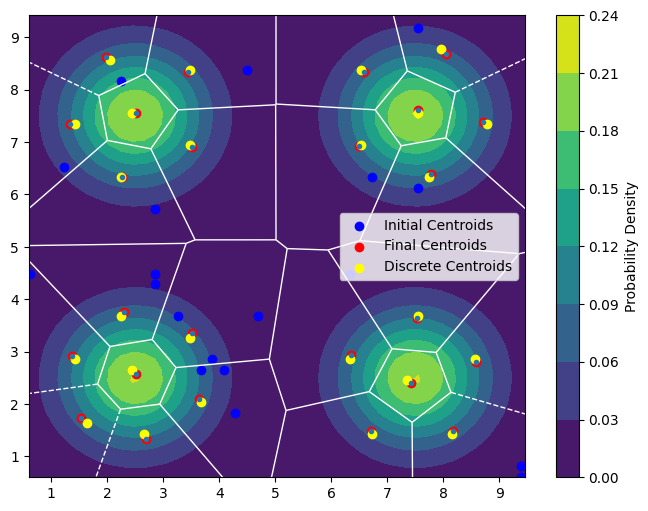

[8.16326531 1.42857143]
[7.34693878 2.44897959]
[1.63265306 1.63265306]
[6.73469388 1.42857143]
[8.57142857 2.85714286]
[2.65306122 1.42857143]
[3.67346939 2.04081633]
[3.46938776 3.26530612]
[2.44897959 2.65306122]
[6.32653061 2.85714286]
[2.24489796 3.67346939]
[1.42857143 2.85714286]
[2.24489796 6.32653061]
[7.55102041 3.67346939]
[3.46938776 6.93877551]
[8.7755102  7.34693878]
[7.75510204 6.32653061]
[6.53061224 6.93877551]
[1.42857143 7.34693878]
[2.44897959 7.55102041]
[3.46938776 8.36734694]
[7.55102041 7.55102041]
[2.04081633 8.57142857]
[7.95918367 8.7755102 ]
[6.53061224 8.36734694]


In [ ]:
"""Plot centroids
"""
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d

# Gaussians (weight)
fig, ax = plt.subplots(figsize=(8, 6))
contour = ax.contourf(X, Y, z_total, cmap='viridis')
fig.colorbar(contour, ax=ax, label='Probability Density')

# Centroids
ax.scatter(initial_centroids[:, 0], initial_centroids[:, 1], color='blue', label='Initial Centroids')
ax.scatter(final_centroids[:, 0], final_centroids[:, 1], color='red', label='Final Centroids')
ax.scatter(d_centroids[:, 0], d_centroids[:, 1], color='yellow', label='Discrete Centroids')

# Voronoi diagram
vor = Voronoi(final_centroids)
voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors="white")
ax.legend()
plt.show()
